<b>Machine Learning I / Mini Lab Predictive Analysis</b>
<br><b>Authors:</b> Fabio Savorgnon, Tina Pai, Paritosh Rai, Ellen Lull
<br><b>Data set from:</b> https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

After our initial Exploratory Data Analysis (EDA) project, we needed to pick a model that would predict if a patient would have cardiovascular disease based on the variables available in our data.  These are:  gender, systolic blood pressure, diastolic blood pressure, age, height and weight (which we used to calculate Body Mass Index or BMI), a cholesterol level indicator, a glucose level indicator, and indicators to identify if a patient used alcohol, smoked or was active.    You can view the full descriptions of these data elements in our EDA document.
<br>  

During our EDA, we determined that the factors that had the highest level of correlation to cardiovascular disease were:   Blood pressure, BMI, Age, Cholesterol and Glucose.     However, we didn’t want to limit ourselves to only these.   So, we ran five combinations of these variables.  For each combination of variables, we ran both SVM and Logistical Regression models.  For each combination and method, we ran with scaled data and non-scaled data.   Our findings are documented below.


# Setup

In [108]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

df = pd.read_csv("cardio_train.csv", sep=";")



# Clean data

In [107]:

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# bin blood pressure groups based on the api hi/ lo variables
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable

# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2
if 'cardio' in df:
    y = df['cardio'].values
    del df['cardio']
    X = df.values



# Model Variable Selection Options

1. 'ap_hi' (highest co-relation)
2. 'bmi', 'ap_hi', 'ap_lo','cholesterol','age'
3. 'bmi', 'age', ‘bp’, 'cholesterol'
4. ‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol'
5. 'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active', 'weight' (all variable)



## train test split

In [11]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

## SVM Baseline model (ap_hi only)

### Not Scaled

In [12]:
X = df[['ap_hi']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.73250159 0.73526004 0.7308654 ]


### Scaled

In [13]:
X = df[['ap_hi']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.73404774 0.74246148 0.73252425]


## SVM using BMI, age, ap_hi, ap_lo, cholesterol

### Not Scaled

In [14]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.53986612 0.62336674 0.52498432]


### Scaled

In [15]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77951507 0.77354173 0.78094742]


# Hyperparameter Tuning

In [16]:
from sklearn.model_selection import GridSearchCV

### SVM

In [17]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

param_grid = [
  {'classifier__loss': ['modified_huber'],
   'classifier__penalty': ['l1', 'l2', 'elasticnet'],
   'classifier__alpha': [.001, .01, .05, .1, .5, 1]}
 ]

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier())])

clf = GridSearchCV(svm, param_grid, scoring="roc_auc")
clf.fit(X, y)

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',


In [18]:
clf.best_params_

{'classifier__alpha': 0.05,
 'classifier__loss': 'modified_huber',
 'classifier__penalty': 'l1'}

In [19]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best auc: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    


Best auc: 0.776160 using {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.774428 (0.001811) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.774637 (0.002192) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.774976 (0.000961) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.775287 (0.001574) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.774764 (0.001685) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.775304 (0.000762) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.776160 (0.000934) with: {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.775517 (0.00

## Probability Calibration

In [20]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
from sklearn.calibration import CalibratedClassifierCV

model = clf.best_estimator_ #this was alpha=.1, loss='modified_huber', penalty='elasticnet'
calibrator = CalibratedClassifierCV(model, cv=3)

aucs = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77180295 0.77125281 0.77599423]


## ROC

SVM Model ROC AUC=0.771


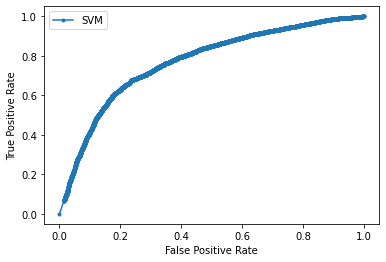

In [21]:
# roc curve and auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

std_scl = StandardScaler()
scl_obj = std_scl.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

model.fit(X_train, y_train)

# predict probabilities
svm_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores\
print('SVM Model ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
pyplot.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Find probability threshold for best accuracy

In [22]:
svm_probs

array([0.3780832 , 0.64422128, 0.29739713, ..., 0.39910043, 0.34630638,
       0.31201971])

In [23]:
alphas = np.arange(0, 1, .1)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))


NameError: name 'mt' is not defined

### tune a little finer

In [24]:
alphas = np.arange(.4, .6, .01)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))



NameError: name 'mt' is not defined

### Logistic Regression

In [93]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

In [29]:
#data setup

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Data Cleanup¶

#### Weight and Height

In [30]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

#### BP Clean up

In [31]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [32]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

### Add bp

In [33]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below

In [34]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [35]:
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bp,bp1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4,Hyper_Stage2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,3,Hyper_Stage1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,4,Hyper_Stage2
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,29.384676,3,Hyper_Stage1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,37.729725,3,Hyper_Stage1


### Options
Following are combo I selected based on high correlation and removing

'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
'ap_hi' (highest co-relation)
'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)

In [36]:
df=df1

In [37]:
#df
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','gluc','smoke','alco','active','cardio','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

In [38]:
#df1.head(5)

In [39]:
#df.head(5)

### Option 1 model

In [40]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [41]:
#make a grid search for logistic regression


param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression(max_iter=1000)
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

{'mean_fit_time': array([0.73809481, 0.69232376, 0.53171659, 0.62112919, 0.51854928,
        0.10572926, 0.10248725, 0.10240261, 0.10457873, 0.10128705]),
 'std_fit_time': array([0.13873654, 0.1951999 , 0.12009902, 0.02753307, 0.12872646,
        0.00354071, 0.00061427, 0.00061142, 0.00369769, 0.00038242]),
 'mean_score_time': array([0.00534296, 0.00509683, 0.00519172, 0.0049142 , 0.00470233,
        0.00391833, 0.00398342, 0.00417916, 0.00388598, 0.00391905]),
 'std_score_time': array([4.89213080e-04, 5.58662448e-04, 4.15123803e-04, 2.43121831e-04,
        9.95764170e-05, 3.43258360e-05, 9.16771022e-05, 4.37950652e-04,
        3.32358122e-05, 5.30920341e-05]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2'

In [42]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.779616 using {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.779615 (0.002683) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.779559 (0.002610) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.779584 (0.002675) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.779571 (0.002612) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.779616 (0.002682) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.617244 (0.002034) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.617243 (0.002034) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.617243 (0.002034) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.617243 (0.002034) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.617243 (0.002034) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [43]:

from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l1', C=1000, class_weight=None, solver='liblinear' ) # get object


In [44]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7801115816225362
confusion matrix
 [[3419 1286]
 [1694 4212]]
====Iteration 1  ====
auc 0.7824393771090845
confusion matrix
 [[3476 1253]
 [1719 4163]]
====Iteration 2  ====
auc 0.7781931670206874
confusion matrix
 [[3437 1310]
 [1712 4152]]


#### train test split

In [45]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Scaling

#### Logistic Regression Scaled

In [46]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

### Hyper Parameter Tuning

In [47]:

#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_



{'mean_fit_time': array([0.06303493, 0.11407797, 0.06273762, 0.11424716, 0.05966989,
        0.12216131, 0.05685806, 0.10961739, 0.05684702, 0.12502106,
        0.03984698, 0.13622173, 0.11214105, 0.04197955, 0.1363581 ,
        0.11227743, 0.04836861, 0.15743287, 0.11914889, 0.0439144 ,
        0.16326865, 0.10098131, 0.04156176, 0.12570858, 0.10267504]),
 'std_fit_time': array([8.72983526e-03, 1.43868645e-02, 6.67807450e-03, 6.84350494e-03,
        2.11209196e-03, 9.53525280e-03, 1.84806824e-03, 1.02222567e-02,
        1.71748014e-03, 3.13272176e-02, 3.14206642e-04, 1.26467530e-02,
        9.86447455e-03, 3.64442744e-04, 7.64107391e-03, 7.13745486e-03,
        7.35142826e-03, 2.17028149e-02, 1.52738687e-03, 1.20658113e-03,
        6.59993797e-03, 4.26270111e-03, 3.92642578e-05, 5.04636466e-03,
        2.91746365e-03]),
 'mean_score_time': array([0.00536402, 0.0050474 , 0.00534614, 0.00495593, 0.00553473,
        0.00549761, 0.0052406 , 0.00501982, 0.0051802 , 0.0049026 ,
        0.00

In [48]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.774432 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.774429 (0.001431) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.774432 (0.001433) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.774417 (0.001427) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.774419 (0.001429) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.774415 (0.001426) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.774416 (0.001426) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.774416 (0.001427) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.774415 (0.001426) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.774414 (0.001426)

In [49]:
lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

0.7781845092944463
[0.7118085  0.71143153 0.71105457]


In [50]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7672669989102913
confusion matrix
 [[3354 1340]
 [1775 4142]]
====Iteration 1  ====
auc 0.7761846861904667
confusion matrix
 [[3463 1286]
 [1760 4102]]
====Iteration 2  ====
auc 0.7770129394086172
confusion matrix
 [[3364 1315]
 [1734 4198]]


In [51]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [52]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [53]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [54]:
model=clf.best_estimator_.fit(X,y)

In [55]:
model.named_steps["classifier"].coef_

array([[0.29727571, 0.89571887, 0.12864879, 0.28283122, 0.10075233]])

#### precision recall curve

Logistic: ROC AUC=0.777


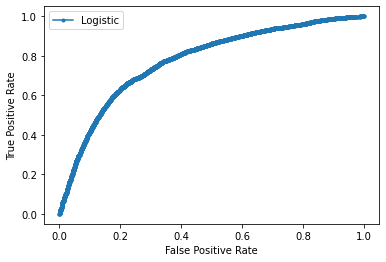

In [56]:
# roc curve and auc


lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

### Option 3 model

In [58]:
#data setup
import pandas as pd

df1 = pd.read_csv("C:\Paritosh\SMU\SMUMSDS-ML1\cardio_train.csv", sep=";")
df1.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#### Data Cleanup

#### Weight and Heigh

In [59]:
# We address the weight with reasonable weight, the other values probably are a mistake
df1 = df1[df1["weight"] < 200]
df1 = df1[df1["weight"] > 55]

# We address the height, the other values probably are a mistake
df1 = df1[df1["height"] < 200]
df1 = df1[df1["height"] > 130]

#### BP Clean up

In [60]:
# Keeping only reasonable blood pressure measurements
df1 = df1[df1["ap_hi"] < 200]
df1 = df1[df1["ap_hi"] > 110]
df1 = df1[df1["ap_lo"] < 150]
df1 = df1[df1["ap_lo"] > 60]

#### Add BMI

In [61]:
# compute the body mass index based on weight and height
df1['bmi'] = df1['weight'] / (df1['height']/100)**2

#### Add bp

In [62]:
# bin blood pressure groups based on the api hi/ lo variables
df1['bp'] = np.where((df1.ap_hi < 120) & (df1.ap_lo < 80), 1, 0)
df1['bp'] = np.where((df1.ap_hi >= 120) & (df1.ap_hi < 130) & (df1.ap_lo < 80), 2, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 130) & (df1.ap_hi < 140) | ((df1.ap_lo >= 80) & (df1.ap_lo < 90)), 3, df1.bp)
df1['bp'] = np.where((df1.ap_hi >= 140) | (df1.ap_lo >= 90), 4, df1.bp)
df1['bp'] = np.where((df1.ap_hi > 180) | (df1.ap_lo > 120), 5, df1.bp)
df1['bp1'] = pd.cut(df1.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable


In [63]:
# Our dataset contains primarily people in hypertension stage 1 and stage 2. See the counts below.

In [64]:

#show counts of people in each BMI group

df_grouped = df1.groupby(by='bp1')

df_grouped[['bp']].count()

,bp
bp1,
Normal,177
Elevated,2472
Hyper_Stage1,28219
Hyper_Stage2,22049
Hyper_Stage3,136


In [65]:
# df1.head(5)

### Options 3
Following are combo I selected based on high correlation and removing

'bmi', 'ap_hi', 'ap_lo','cholesterol','age' (top 5 co-relation)
'ap_hi' (highest co-relation)
'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active' (all variable)
‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol' (replace BMI with weight and drop Height as co-relation is low for height)
'bmi', 'age', ‘bp’, 'cholesterol' (high correlation and removed colinear once)

In [66]:
df=df1
df1
# option 1
y = df['cardio'].values # get the labels we want
df.drop(['id','gender','height','weight','cardio','bp','bp1'], axis =1, inplace = True) # get rid of the class label
#df.head(5)
X = df.values # Option1
#X

In [67]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l1'],
   'solver': ['liblinear']},
  {'C': [.1, 1, 10, 100, 1000],
   'penalty': ['l2'], 
   'solver': ['lbfgs']},
 ]

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, scoring="roc_auc",cv=cv_object)
clf.fit(X, y)


clf.cv_results_

/Users/fabiosavorgnan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


{'mean_fit_time': array([1.01911473, 0.73958619, 0.8288041 , 0.92983778, 1.03173176,
        0.16737366, 0.21270116, 0.18434064, 0.19325161, 0.19476676]),
 'std_fit_time': array([0.30720366, 0.22861777, 0.22264783, 0.11674176, 0.28234444,
        0.04232127, 0.06889076, 0.05766923, 0.05211009, 0.0693417 ]),
 'mean_score_time': array([0.0049866 , 0.00567842, 0.00476209, 0.00512369, 0.0049696 ,
        0.00417042, 0.00452089, 0.00454736, 0.00437474, 0.00462921]),
 'std_score_time': array([3.56044141e-04, 5.11431397e-04, 7.45596903e-05, 3.71205826e-04,
        3.00965535e-04, 2.65431095e-04, 6.03058985e-04, 7.61882004e-04,
        5.28215595e-04, 5.43814481e-04]),
 'param_C': masked_array(data=[0.1, 1, 10, 100, 1000, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l1', 'l1', 'l1', 'l1', 'l2', 'l2', 'l2', 'l2'

In [69]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.779621 using {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.779592 (0.004271) with: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.779319 (0.004471) with: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
0.779509 (0.004332) with: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.779621 (0.004232) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.779600 (0.004255) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.641860 (0.020173) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.641868 (0.020176) with: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.641874 (0.020179) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.641868 (0.020177) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.642065 (0.020288) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object



In [71]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [72]:
from sklearn import metrics as mt
lr_clf = LogisticRegression(penalty='l1', C=0.1, class_weight=None, solver='liblinear' ) # get object



In [73]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.7730773450990129
confusion matrix
 [[3302 1338]
 [1764 4207]]
====Iteration 1  ====
auc 0.7801297475710873
confusion matrix
 [[3344 1314]
 [1697 4256]]
====Iteration 2  ====
auc 0.7803719090561467
confusion matrix
 [[3318 1258]
 [1744 4291]]


#### train test split

In [74]:
#make CV spit 80/20 object
from sklearn.model_selection import ShuffleSplit
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

### Scaling

In [75]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#### Logistic Regression Scaled

In [76]:
# from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

### Hyper Parameter Tuning

In [77]:
#make a grid search for logistic regression
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l1'],
   'classifier__solver': ['liblinear', 'saga']},
  {'classifier__C': [.1, 1, 10, 100, 1000],
   'classifier__penalty': ['l2'], 
   'classifier__solver': ['lbfgs', 'sag', 'saga']},
 ]

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='lbfgs'))])
clf = GridSearchCV(lr, param_grid, scoring="roc_auc", cv=cv_object)
clf.fit(X, y)


clf.cv_results_

{'mean_fit_time': array([0.07257692, 0.14458529, 0.06802575, 0.13850236, 0.07007925,
        0.14684892, 0.06656631, 0.15125871, 0.07075365, 0.14201148,
        0.04654709, 0.15175033, 0.13586386, 0.04601932, 0.17247494,
        0.14311385, 0.04588985, 0.1914653 , 0.15739894, 0.04672837,
        0.17678626, 0.14767337, 0.04630144, 0.18031963, 0.144478  ]),
 'std_fit_time': array([6.90399927e-03, 9.20050534e-03, 2.72165997e-03, 8.53927906e-03,
        4.79306440e-03, 9.26575847e-03, 2.67503454e-03, 5.03648177e-03,
        2.16555227e-03, 1.08997560e-02, 7.75722375e-04, 6.65199844e-03,
        4.41734259e-03, 2.11692428e-04, 9.46471961e-03, 1.21138408e-03,
        7.43325763e-05, 1.31467118e-02, 1.37294400e-02, 5.72556381e-04,
        6.90647634e-03, 2.35872527e-03, 2.25159501e-04, 9.25655725e-03,
        7.12360648e-03]),
 'mean_score_time': array([0.00548172, 0.00501696, 0.00537785, 0.00503127, 0.00534542,
        0.00500663, 0.0052917 , 0.00493964, 0.00527056, 0.00518346,
        0.00

In [78]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.778379 using {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.778377 (0.000527) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.778379 (0.000527) with: {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.778333 (0.000528) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.778333 (0.000528) with: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.778329 (0.000529) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.778329 (0.000530) with: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.778328 (0.000529) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
0.778329 (0.000529) with: {'classifier__C': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.778329 (0.000528)

In [79]:

lr_clf = make_pipeline(StandardScaler(), LogisticRegression(C= 0.1, penalty= 'l1', solver= 'saga'))
model_s=lr_clf
model_s.fit(X_train, y_train)
pred_prob_s = model_s.predict_proba(X_test)
auc_score_s = roc_auc_score(y_test, pred_prob_s[:,1])
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(auc_score_s)
print(accuracies)

0.7805098717562471
[0.71454151 0.70982942 0.71897088]


In [80]:
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    #acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
   # print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
auc 0.76907517656087
confusion matrix
 [[3274 1298]
 [1824 4215]]
====Iteration 1  ====
auc 0.7823302391154949
confusion matrix
 [[3380 1260]
 [1752 4219]]
====Iteration 2  ====
auc 0.7800186849819681
confusion matrix
 [[3430 1314]
 [1640 4227]]


In [81]:
"""lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))
accuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)
print(accuracies)
"""

"lr_clf = make_pipeline(StandardScaler(), LogisticRegression( solver= 'lbfgs'))\naccuracies = cross_val_score(lr_clf, X, y=y, cv=cv_object)\nprint(accuracies)\n"

In [82]:
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [83]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [84]:
model=clf.best_estimator_.fit(X,y)

In [85]:
model.named_steps["classifier"].coef_

array([[ 0.29565058,  0.90210811,  0.12967679,  0.32372086, -0.07848146,
        -0.03660841, -0.04822841, -0.09434926,  0.10184541]])

#### precision recall curve

Logistic: ROC AUC=0.780


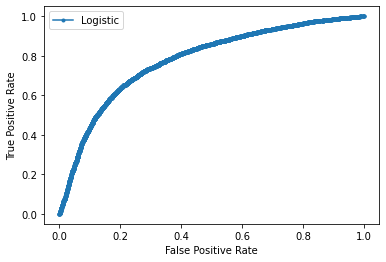

In [86]:
# roc curve and auc


lr_clf.fit(X_train, y_train)

# predict probabilities
lr_probs = lr_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores\
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

##### Follwoing is the summary of Analysis that was run on Logistic Regression and SVM with Five options in unscaled and scaled options.

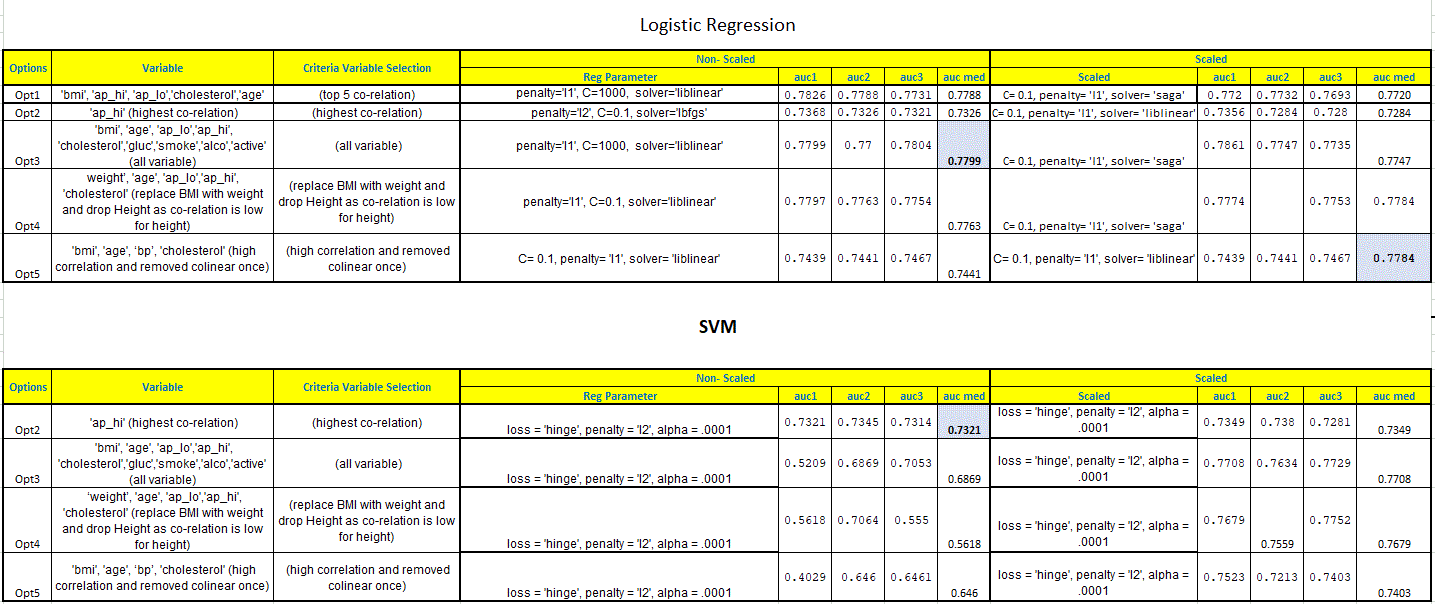

# Model 1 Logistic Regression

In [111]:
df = pd.read_csv("cardio_train.csv", sep=";")
# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2

# df have the selected variables
df = df[['cholesterol','ap_hi','ap_lo','bmi','age', 'cardio']] 

# we want to predict the X and y data as follows:
if 'cardio' in df:
    y = df['cardio'].values # get the labels we want
    del df['cardio'] # get rid of the class label
    X = df.values # use everything else to predict!

In [113]:
#make CV spit 80/20 object
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

#LogisticRegression(solver='lbfgs')
lr_clf = LogisticRegression(penalty='l1', C=1000, class_weight=None, solver='liblinear' ) # get object
 
iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)
    y_hat = lr_clf.predict(X_test)
    y_prob=lr_clf.predict_proba(X_test)[:,1]

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    auc = mt.roc_auc_score(y_test,y_prob)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("auc", auc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.7134106116294412
auc 0.7745217669903235
confusion matrix
 [[3369 1284]
 [1757 4201]]
====Iteration 1  ====
accuracy 0.7116200169635284
auc 0.7770770340556945
confusion matrix
 [[3386 1293]
 [1767 4165]]
====Iteration 2  ====
accuracy 0.708038827631703
auc 0.7739213684254341
confusion matrix
 [[3354 1338]
 [1760 4159]]


## Interpretation of the weight 

In [103]:
# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

cholesterol has weight of 0.40939455590629564
ap_hi has weight of 0.06069578704484562
ap_lo has weight of 0.01480732822671338
bmi has weight of 0.019261720289480838
age has weight of 0.00011582635182984165


## Graph of the weight

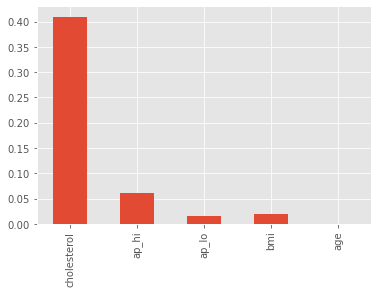

In [104]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights.plot(kind='bar')
plt.show()

You can see how the selection of the variablesfor the logistic regression gives us three stable model in the training split with accuracy result of 71.3%, 71.1 %, and 70.8 %. It also give us a stable AUC of 0.774, 0.777 and 0,773. 
As you can see in the graphic above cholesterol has the highest weight to predic a cardiac event, it has a weight of 0.409. It is followed by blood pressure (ap_hi), which has a weight of 0.06, and blood pressure(ap_lo), which has a weight of 0.014.The blood pressure high has more weight to predic a cardiac event than the low blood pressure. Also with less weight to predict cardiac event in relation to blood pressure high but slightly more than blood pressure low is the bmi, with a weight of 0.019. Finally with the lowest weight to predic cardiac events is the age with a weight of 0.0001.